## Goals: Training the _Final_ Models

This notebook trains the model on the full _baseline_dataset_ for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic _regions_.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.


In [ ]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    DotProduct,
    ExpSineSquared,
    WhiteKernel,
    Matern,
    ConstantKernel as C,
)
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.custom_models import VotingRandomForestQuantileRegressor
from src.utils.model import split_dataset, compare_models_per_station

##### Constants :

- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.


In [ ]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_TRANSFORMS = [
    "rm_gnv_st",
    "pca",
    "snow_index",
    # "oh_enc_date",
    "cyc_enc_date",
    "clust_index",
    "clust_hydro",
    # "scl_feat",
    "scl_feat_wl", # Scale all except waterflow lag
    "scl_catch",
]

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)


MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4

FINAL_MODELS = [
    # "qrf_bagging",
    # "qrf_voting",
    "qrf",
    # "gbr",
    # "gpr"
]

gpr = {}
qrf = {}
qrf_bagging = {}
qrf_voting = {}
gbr = {}

COLUMNS_TO_DROP = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

### 2. Data Loading

Load in the baseline datasets, create the directory to save models.


In [ ]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

Data pre-processing removal of unnecessary columns, setup of the target


In [ ]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]

### 2. Models training

#### a. QRF Bagging


In [ ]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

- **Data Preparation:**
  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).


In [ ]:
if "qrf_bagging" in FINAL_MODELS:

    print("Training qrf_bagging")

    initial_model = RandomForestQuantileRegressor(
        n_estimators=45,
        min_samples_split=2,
        min_samples_leaf=9,
        max_features=None,
        max_depth=30,
    )
    train_mapie_svm, val_mapie_svm, val_temporal = split_dataset(
        dataset_train, 0.75, TIME_VALIDATION
    )

    X_train_mapie_svm = train_mapie_svm.drop(columns=COLUMNS_TO_DROP)
    X_train_mapie_svm = X_train_mapie_svm.drop(columns=["station_code"])
    print(len(X_train_mapie_svm.columns))
    y_train_mapie_svm = {}
    for i in range(0, NUMBER_OF_WEEK):
        y_train_mapie_svm[i] = train_mapie_svm[f"water_flow_week{i+1}"]

    X_val = val_mapie_svm.drop(columns=COLUMNS_TO_DROP)
    X_val = X_val.drop(columns=["station_code"])
    y_val = {}
    y_val[0] = val_mapie_svm["water_flow_week1"]
    for i in range(1, NUMBER_OF_WEEK):
        y_val[i] = val_mapie_svm[f"water_flow_week{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        # Initialize and train Model
        qrf_bagging[i] = BaggingRegressor(
            estimator=initial_model, n_estimators=3, random_state=0
        )
        qrf_bagging[i].fit(X_train_mapie_svm, y_train_mapie_svm[i])

        # save model with date
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

        model_path = f"{MODEL_DIR}final/qrf_bagging_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_bagging[i], model_path)

#### b. QRF Voting


In [ ]:
if "qrf_voting" in FINAL_MODELS:
    print("Training qrf_voting")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        qrf_voting[i] = VotingRandomForestQuantileRegressor()
        qrf_voting[i].fit(X_train, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_voting_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_voting[i], model_path)

#### c. GradientBoostingRegressor


In [ ]:
if "gbr" in FINAL_MODELS:
    gbr = {}
    X_train_gbr = X_train.drop(columns=["station_code"])
    print("Training GradientBoostingRegressor")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        gbr[i] = {}
        common_params = dict(
            learning_rate=0.05,
            n_estimators=200,
            max_depth=2,
            min_samples_leaf=9,
            min_samples_split=9,
        )

        for alpha in [0.05, 0.5, 0.95]:
            print(f"Training quantile {alpha}")
            gbr_model = GradientBoostingRegressor(
                loss="quantile", alpha=alpha, **common_params
            )
            key = "lower" if alpha == 0.05 else "median" if alpha == 0.5 else "upper"
            gbr[i][key] = gbr_model.fit(X_train_gbr, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gbr_quantile_{time}_week_{i}.pkl"
        joblib.dump(gbr[i], model_path)

#### d. QRF


In [ ]:
X_train_qrf = X_train.drop(columns=["station_code"])

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor

        qrf[i] = RandomForestQuantileRegressor(
            n_estimators=60,
            min_samples_split=20,
            min_samples_leaf=9,
            max_features=None,
            max_depth=13,
            bootstrap=True,
            random_state=42,
        )
        qrf[i].fit(X_train_qrf, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


#### e. GPR


In [ ]:
selected_kernel = [
    # "rbf",
    "dot",
    # "mattern",
    # "exp-sin",
]
X_train_gpr = X_train.drop(columns=["station_code"])
train_proportion = 0.2

if "gpr" in FINAL_MODELS:

    if "dot" in selected_kernel:
        kernel = DotProduct() * DotProduct() + WhiteKernel()
    if "rbf" in selected_kernel:
        kernel = RBF(length_scale=1.0, length_scale_bounds=(0.5, 5.0))
    #   kernel = RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1.5)
    if "mattern" in selected_kernel:
        # kernel = C(1.0, (1e-4, 1e5)) * Matern(length_scale=1.0, nu=1.5, length_scale_bounds=(1e-5, 1e4))
        kernel = Matern()
    if "exp-sin" in selected_kernel:
        kernel = ExpSineSquared()

    print(f"Using {"".join(selected_kernel)} kernel")

    for i in range(NUMBER_OF_WEEK):
        X_sampled, _, y_sampled, _ = train_test_split(
            X_train_gpr, y_train[i], train_size=train_proportion, random_state=42
        )
        print(f"Training on {X_sampled.shape} samples")
        print(f"Training week {i}")
        # Train GaussianProcessRegressor
        gpr[i] = GaussianProcessRegressor(kernel=kernel, random_state=42)
        gpr[i].fit(X_sampled, y_sampled)

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gpr_quantile_{"".join(selected_kernel)}_{time}_week_{i}.pkl"
        joblib.dump(gpr[i], model_path)

### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [ ]:
preds = {}

if "qrf_voting" in FINAL_MODELS:
    location_confidences = [1.9, 1.95, 2]

    for confidence_value in location_confidences:
        preds[confidence_value] = {}
        for i in range(NUMBER_OF_WEEK):
            qrf_voting[i].adjust_weights(location_confidence=confidence_value)
            preds[confidence_value][i] = {}
            preds[confidence_value][i] = qrf_voting[i].predict(X_train)
            preds[confidence_value][i]["y_true"] = y_train[i]

if "gpr" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Predicting week {i}")
        y_pred, y_std = gpr[i].predict(
            X_train.drop(columns=["station_code"]), return_std=True
        )
        y_lower = y_pred - ((y_pred * 0.6) * y_std)
        y_upper = y_pred + ((y_pred * 0.6) * y_std)

        preds[i] = {}
        preds[i]["mean"] = y_pred
        preds[i]["lower"] = y_lower
        preds[i]["upper"] = y_upper
        preds[i]["y_true"] = y_train[i]

In [16]:
import matplotlib.pyplot as plt

if "qrf_voting" in FINAL_MODELS:
    for confidence_value in location_confidences:

        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        print(f"Using {confidence_value} location confidence")

        for i in range(NUMBER_OF_WEEK):
            axes[i].plot(preds[confidence_value][i][27600:27700])
            axes[i].set_title(f"Data from week {i}")

    plt.tight_layout()
    plt.show()

if "gpr" in FINAL_MODELS:

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i in range(NUMBER_OF_WEEK):
        axes[i].plot(pd.DataFrame(preds[i])[27600:27630])
        axes[i].set_title(f"Data from week {i}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

In [17]:
import matplotlib.pyplot as plt

if "qrf_voting" in FINAL_MODELS:
    for confidence_value in location_confidences:

        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        print(f"Using {confidence_value} location confidence")

        for i in range(NUMBER_OF_WEEK):
            axes[i].plot(preds[confidence_value][i][27600:27700])
            axes[i].set_title(f"Data from week {i}")

    plt.tight_layout()
    plt.show()

if "gpr" in FINAL_MODELS:

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i in range(NUMBER_OF_WEEK):
        axes[i].plot(pd.DataFrame(preds[i])[27600:27700])
        axes[i].set_title(f"Data from week {i}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

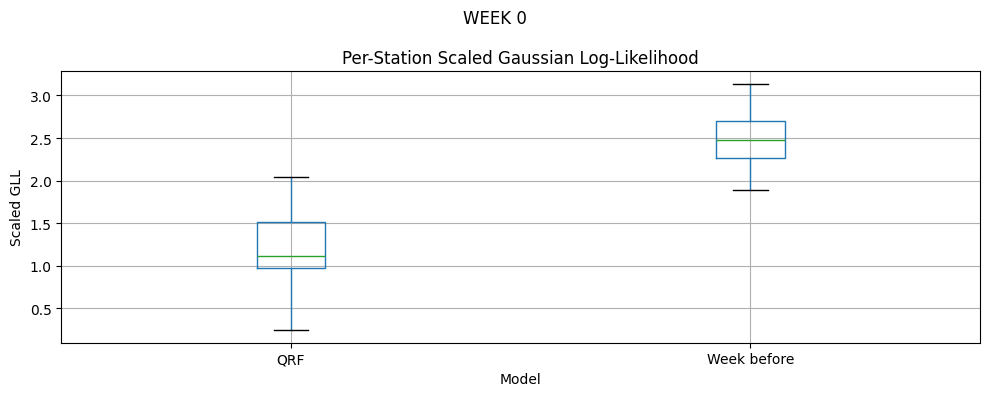

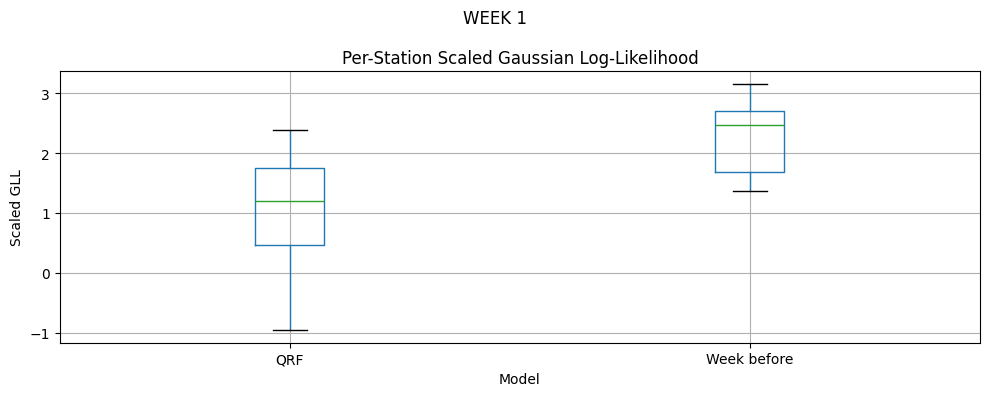

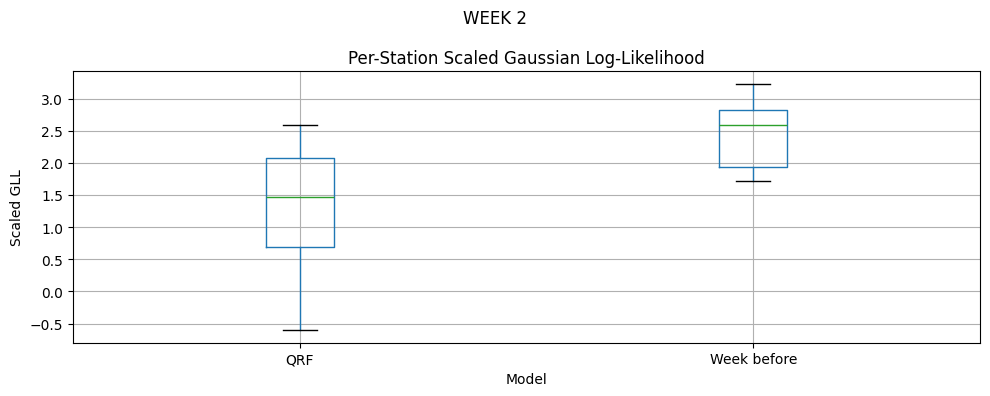

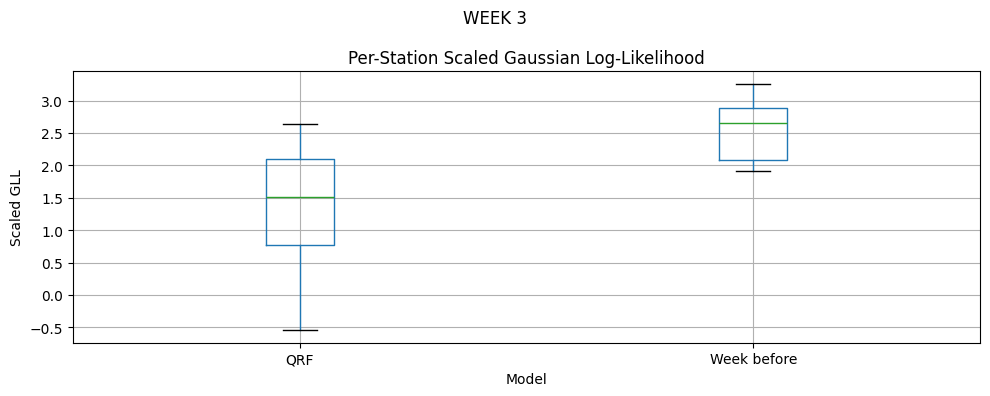

In [ ]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append(
        {
            "model": "Week before",
            "prediction": baseline_day_before,
            "dataset": "train",
            "stations": y_train_stations,
            "prediction_interval": None,
        }
    )

    if "qrf_bagging" in FINAL_MODELS:
        y_pred_qrf_bagging = np.mean(
            [est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], axis=0
        )
        y_pis_qrf_bagging = np.stack(
            [
                np.quantile(
                    [est.predict(X_train_eval) for est in qrf_bagging[i].estimators_],
                    0.05,
                    axis=0,
                ),
                np.quantile(
                    [est.predict(X_train_eval) for est in qrf_bagging[i].estimators_],
                    0.95,
                    axis=0,
                ),
            ],
            axis=1,
        )

        predictions.append(
            {
                "model": "QRF bagging",
                "prediction": y_pred_qrf_bagging,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf_bagging,
            }
        )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        predictions.append(
            {
                "model": "QRF",
                "prediction": y_pred_qrf,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf,
            }
        )
    if "qrf_voting" in FINAL_MODELS:

        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_qrf_voting = y_preds_voting["mean"]
            y_pis_qrf_voting = np.stack(
                [y_preds_voting["lower"], y_preds_voting["upper"]], axis=1
            )

            predictions.append(
                {
                    "model": f"QRF Voting lc_val{confidence_value}",
                    "prediction": y_pred_qrf_voting,
                    "dataset": "train",
                    "stations": y_train_stations,
                    "prediction_interval": y_pis_qrf_voting,
                }
            )
    if "gpr" in FINAL_MODELS:

        y_preds_gpr = preds[i]
        y_pred_qrf_voting = y_preds_gpr["mean"]
        y_pis_qrf_voting = np.stack(
            [y_preds_gpr["lower"], y_preds_gpr["upper"]], axis=1
        )

        predictions.append(
            {
                "model": f"GPR",
                "prediction": y_pred_qrf_voting,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf_voting,
            }
        )

    if "gbr" in FINAL_MODELS:
        X_train_gbr = X_train.drop(columns=["station_code"])
        y_pred_qrf = gbr[i]["median"].predict(X_train_eval)
        y_pis_qrf = np.stack(
            [
                gbr[i]["lower"].predict(X_train_eval),
                gbr[i]["upper"].predict(X_train_eval),
            ],
            axis=1,
        )
        predictions.append(
            {
                "model": "GBR",
                "prediction": y_pred_qrf,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf,
            }
        )
    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood",
        title=f"WEEK {i}",
    )

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [ ]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "qrf_bagging" in FINAL_MODELS:
        y_pred_qrf_bagging = np.mean(
            [
                est.predict(X_train_eval, quantiles="mean")
                for est in qrf_bagging[i].estimators_
            ],
            axis=0,
        )
        y_pis_qrf_bagging = np.mean(
            np.stack(
                [
                    [
                        est.predict(X_train_eval, quantiles=[ALPHA / 2])
                        for est in qrf_bagging[i].estimators_
                    ],
                    [
                        est.predict(X_train_eval, quantiles=[1 - ALPHA / 2])
                        for est in qrf_bagging[i].estimators_
                    ],
                ],
                axis=1,
            ),
            axis=0,
        )
        print(y_pred_qrf_bagging.shape)
        print(y_pis_qrf_bagging.shape)
        coverage = (y_train[i].values >= y_pis_qrf_bagging[0, :]) & (
            y_train[i].values <= y_pis_qrf_bagging[1, :]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

    if "gbr" in FINAL_MODELS:
        y_pred_gbr = gbr[i]["median"].predict(X_train_eval)
        y_pis_gbr = np.stack(
            [
                gbr[i]["lower"].predict(X_train_eval),
                gbr[i]["upper"].predict(X_train_eval),
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_pis_gbr[:, 0]) & (
            y_train[i].values <= y_pis_gbr[:, 1]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

    if "gpr" in FINAL_MODELS:
        y_preds_voting = preds[i]
        y_pred_gbr = y_preds_voting["mean"]
        y_pis_gbr = np.stack([y_preds_voting["lower"], y_preds_voting["upper"]], axis=1)
        coverage = (y_train[i].values >= y_pis_gbr[:, 0]) & (
            y_train[i].values <= y_pis_gbr[:, 1]
        )
        print(
            f"GPR coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (
            y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

    if "qrf_voting" in FINAL_MODELS:
        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_gbr = y_preds_voting["mean"]
            y_pis_gbr = np.stack(
                [y_preds_voting["lower"], y_preds_voting["upper"]], axis=1
            )
            coverage = (y_train[i].values >= y_pis_gbr[:, 0]) & (
                y_train[i].values <= y_pis_gbr[:, 1]
            )
            print(
                f"QRF coverage of the prediction interval for week {i}, lc_val {confidence_value}: {coverage.mean()}"
            )

QRF coverage of the prediction interval for week 0: 0.9661396289076601
QRF coverage of the prediction interval for week 1: 0.9655620532813515
QRF coverage of the prediction interval for week 2: 0.9636488340192044
QRF coverage of the prediction interval for week 3: 0.9612663345606816
